## Project: Build a Traffic Sign Recognition Classifier

In this project, I used a LeNet implementation of a Convolutional Neural Networks to classify traffic signs. Specifically, a model to classify traffic signs from the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset) was developed.


>**Comments:** Only original images were normalized. Newly generated images were generated from the original ones without normalization. Any category of images which had less than 250 images were increased to have 250 images. Generated images were transformed. Removed fc0 dropout
#Hyperparameters
EPOCHS = 25
BATCH_SIZE = 128
rate = 0.001
dropout = 0.7
augment_num = 250

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import os
import csv

# TODO: Fill this in based on where you saved the training and testing data

#fileDir = os.path.dirname(os.path.realpath('__file__'))
#training_file = os.path.join(fileDir, 'traffic-signs-data/train.p')
#validation_file = os.path.join(fileDir, 'traffic-signs-data/valid.p')
#testing_file = os.path.join(fileDir, 'traffic-signs-data/test.p')

training_file = 'traffic-signs-data/train.p'
validation_file = 'traffic-signs-data/valid.p'
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

with open('signnames.csv', mode='r') as f:
    fread = csv.reader(f)
    next(fread, f)
    sign_labels = [rows[1] for rows in fread]
    


## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Data visualization

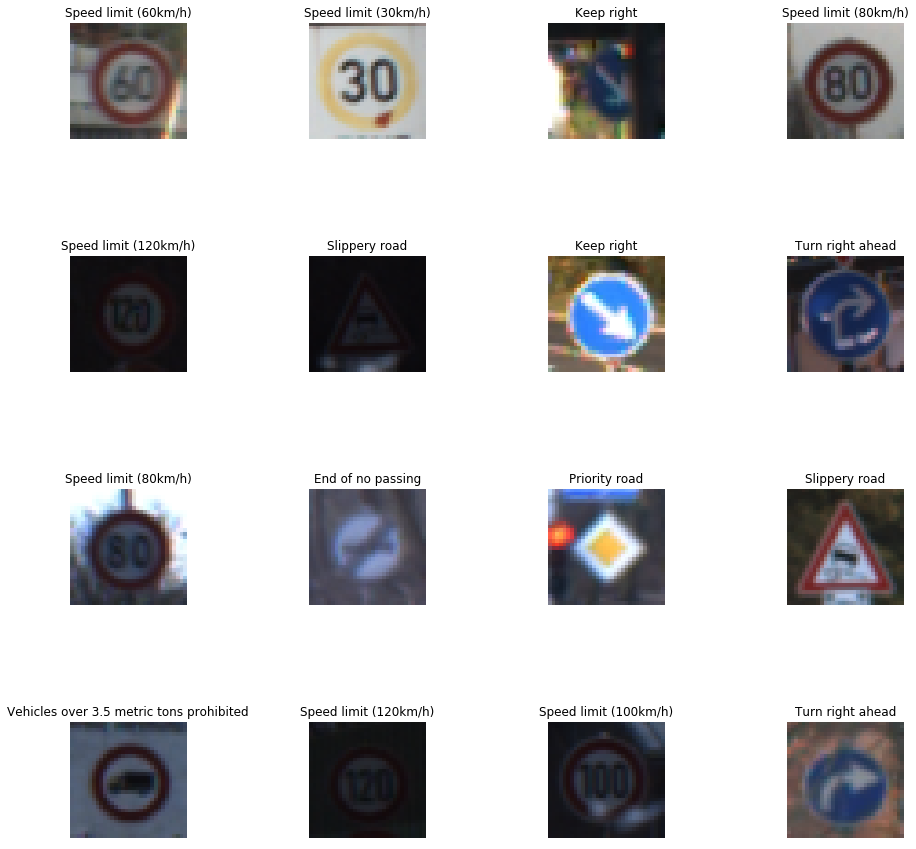

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Visualizations will be shown in the notebook.

%matplotlib inline
import random
import numpy as np
%matplotlib inline

def plot_row_col(rows,cols,X,y):

    plt.figure(figsize = (15,15))
    grid = gridspec.GridSpec(rows,rows)
    # set the spacing between axes.
    grid.update(wspace=1, hspace=1)  

    for i in range(rows*cols):
        img_plt = plt.subplot(grid[i])
        plt.axis('on')
        img_plt.set_xticklabels([])
        img_plt.set_yticklabels([])
        img_plt.set_aspect('equal')
        index = np.random.randint(0,len(X))
        plt.imshow(X[index])
        plt.title(sign_labels[int(y_train[index])])
#        plt.text(2, 4, str(sign_labels[y[index]]), color='k', backgroundcolor='m')
        plt.axis('off')
    plt.show()

plot_row_col(4,4,X_train,y_train)

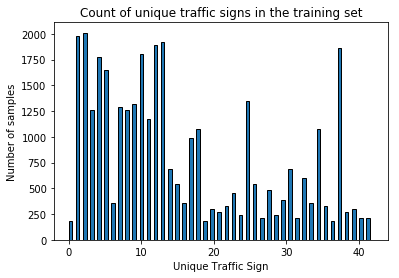

In [5]:
# Plot a histogram with the count of each traffic signs in the training set

plt.hist(y_train, bins=n_classes, edgecolor='black', width=0.5)
plt.title('Count of unique traffic signs in the training set')
plt.xlabel('Unique Traffic Sign')
plt.ylabel('Number of samples')
plt.show()

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

### Pre-process the Data Set (normalization, grayscale, etc.)

Color Image shape before augmentation: (34799, 32, 32, 3)
Adding 70 samples for class 0
Adding 70 samples for class 19
Adding 10 samples for class 24
Adding 40 samples for class 27
Adding 10 samples for class 29
Adding 40 samples for class 32
Adding 70 samples for class 37
Adding 40 samples for class 41
Adding 40 samples for class 42
Color Image shape after augmentation: (35189, 32, 32, 3)


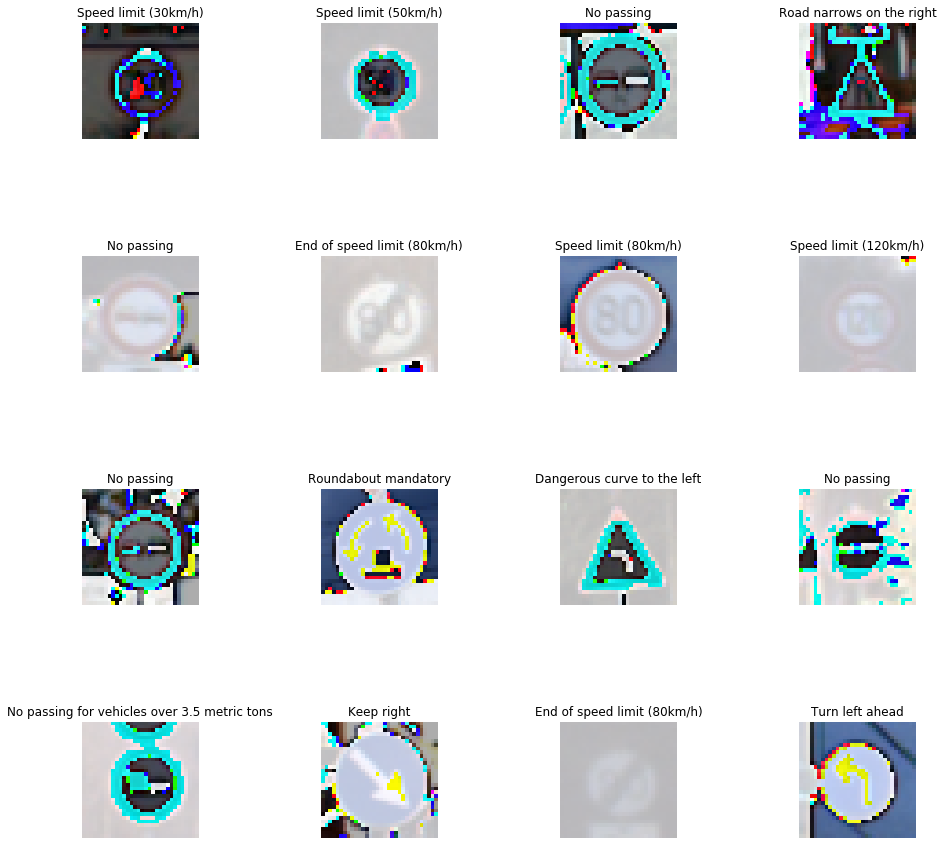

In [6]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

from sklearn.utils import shuffle
from IPython.display import Image
from IPython.display import display
import cv2
import tensorflow as tf
import time

#Hyperparameters
EPOCHS = 25
BATCH_SIZE = 128
rate = 0.001
dropout = 0.7
augment_num = 250

#Save a copy of the original images
X_train_gold = X_train
X_test_gold = X_test
X_valid_gold = X_valid

#Image augmentation functions
def transform_image(image,ang_range,shear_range,trans_range):

    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = image.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    image = cv2.warpAffine(image,Rot_M,(cols,rows))
    image = cv2.warpAffine(image,Trans_M,(cols,rows))
    image = cv2.warpAffine(image,shear_M,(cols,rows))
    
    return image

# n_add is total number of samples in each category after augmenting. If class 0 had 20 samples, n_add=250 will give 250 samples
# after the gen_new_images function (adds only 220 samples in this example)
def gen_new_images(X_train,y_train,n_add,ang_range,shear_range,trans_range):
   
    ## checking that the inputs are the correct lengths
    assert X_train.shape[0] == len(y_train)
    # Number of classes: 43
    n_class = len(np.unique(y_train))
    X_arr = []
    Y_arr = []
    n_samples = np.bincount(y_train)

    for i in range(n_class):
        # Number of samples in each class

        if n_samples[i] < n_add:
            print ("Adding %d samples for class %d" %(n_add-n_samples[i], i))
            for i_n in range(n_add - n_samples[i]):
                img_trf = transform_image(X_train[i_n],ang_range,shear_range,trans_range) 
                X_arr.append(img_trf)
                Y_arr.append(i)
#                print ("Number of images in class %d:%f" %(i, X_arr[0])) 
           
    X_arr = np.array(X_arr,dtype = np.float32())
    Y_arr = np.array(Y_arr,dtype = np.float32())
   
    return X_arr,Y_arr

# Normalise all original training images (images still in colour)
X_train_norm = (X_train - X_train.mean()) / (np.max(X_train) - np.min(X_train))
X_test_norm = (X_test - X_test.mean()) / (np.max(X_test) - np.min(X_test))
X_valid_norm = (X_valid - X_valid.mean()) / (np.max(X_valid) - np.min(X_valid))

# Assign normalized data back to original variables for ease of use
X_train = X_train_norm
X_test = X_test_norm
X_valid = X_valid_norm

print('Color Image shape before augmentation:', X_train.shape)
#Generate new images using the original (not normalized) images
X_train_aug,y_train_aug = gen_new_images(X_train_gold,y_train,augment_num,30,5,5)
## combine the generated images and the original training set
X_train = np.append(X_train, X_train_aug, axis=0)
y_train = np.append(y_train, y_train_aug, axis=0)
print('Color Image shape after augmentation:', X_train.shape)
#print('Asserting Xtrain 0 shape:', X_train.shape[0])
#print('Asserting Xtrain 0 shape:', len(y_train))

plot_row_col(4,4,X_train,y_train)



#### Question 1. Describe how you preprocessed the image data. What techniques were chosen and why did you choose these techniques? Consider including images showing the output of each preprocessing technique. 

#### Answer: All the images were normalized so that the data has mean of zero and equal variance. This helps the model converge faster. Since there was an uneven distribution of the number of images for each class as shown in the histogram of the training set images, I added augmented images for some classes such that the minimum number of images in each class is 250 images. For the augmented images, I applied a transform function which randomly rotates, translates and shears the input image. The total number of training images before & after augmentation were 34799 & 35189 respectively. Images before and after preprocessing were plotted at the end of Step 1 & Step 2 above.

###### References: [Dealing with unbalanced data: Generating additional data by jittering the original image](https://medium.com/@vivek.yadav/dealing-with-unbalanced-data-generating-additional-data-by-jittering-the-original-image-7497fe2119c3)

### Model Architecture

In [7]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
# Adding dropout
#    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    # Adding dropout
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b    

    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    # Adding dropout
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


#### Question 2. Describe what your final model architecture looks like including model type, layers, layer sizes, connectivity, etc.) Consider including a diagram and/or table describing the final model.

#### Answer: I used the LeNet architecture (shown in image below) as-is since I was getting above 93% training and validation accuracy using this model after preprocessing and augmentation of the input training set. The image below shows the number of layers, layer sizes & connectivity of the model. There is further room for improvement experimenting with different models such as the one suggested in the [published baseline model to solve a traffic classifier problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

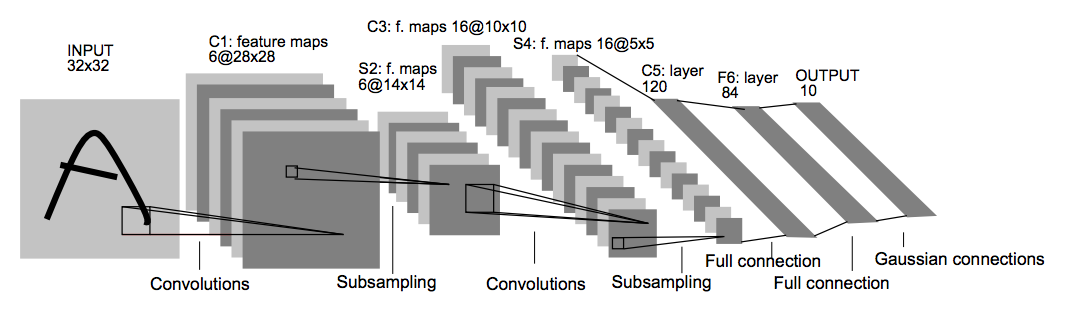
Source: Yann LeCun

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

Training...

EPOCH 1 ...
Drop Out = 0.7
Training Accuracy = 0.472
Validation Accuracy = 0.424
Training Loss = 1.845
Validation Loss = 1.980
Processing time = 5.97 seconds

EPOCH 2 ...
Drop Out = 0.7
Training Accuracy = 0.757
Validation Accuracy = 0.715
Training Loss = 0.866
Validation Loss = 0.990
Processing time = 5.58 seconds

EPOCH 3 ...
Drop Out = 0.7
Training Accuracy = 0.867
Validation Accuracy = 0.807
Training Loss = 0.480
Validation Loss = 0.619
Processing time = 5.58 seconds

EPOCH 4 ...
Drop Out = 0.7
Training Accuracy = 0.907
Validation Accuracy = 0.841
Training Loss = 0.335
Validation Loss = 0.515
Processing time = 5.56 seconds

EPOCH 5 ...
Drop Out = 0.7
Training Accuracy = 0.935
Validation Accuracy = 0.889
Training Loss = 0.244
Validation Loss = 0.372
Processing time = 5.56 seconds

EPOCH 6 ...
Drop Out = 0.7
Training Accuracy = 0.949
Validation Accuracy = 0.898
Training Loss = 0.187
Validation Loss = 0.329
Processing time = 5.61 seconds

EPOCH 7 ...
Drop Out = 0.7
Traini

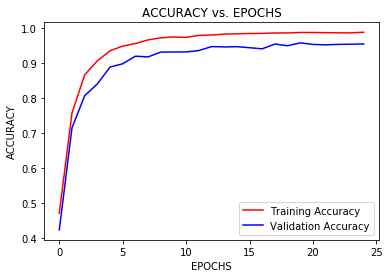

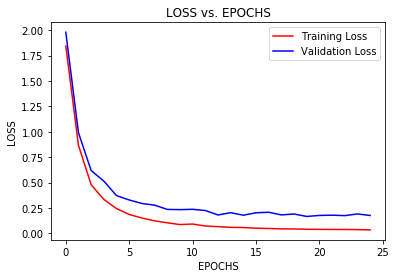

In [8]:
#`x` is a placeholder for a batch of input images.
#`y` is a placeholder for a batch of output labels.

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32, (None))
one_hot_y = tf.one_hot(y, 43)

### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.


logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Evaluate how well the loss and accuracy of the model for a given dataset.

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def evaluate_loss(X_data, y_data):
    num_examples = len(X_data)
    total_loss = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss = sess.run(loss_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_loss += (loss * len(batch_x))
    return total_loss / num_examples

#Train the model
#Run the training data through the training pipeline to train the model.
#Before each epoch, shuffle the training set.
#After each epoch, measure the loss and accuracy of the validation set.
#Save the model after training.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    pts_train_acc = []
    pts_train_loss = []
    pts_valid_acc = []
    pts_valid_loss = []
    
    print("Training...")
    print()
    # Trying different drop_out rates for optimal results
#    for dropout in [0.5, 0.6, 0.7, 0.8, 0.9]:
    for i in range(EPOCHS):
            begin =  time.time()
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
            
            training_accuracy = evaluate(X_train, y_train)
            pts_train_acc.append(training_accuracy)
            training_loss = evaluate_loss(X_train, y_train)
            pts_train_loss.append(training_loss)

            validation_accuracy = evaluate(X_valid, y_valid)
            pts_valid_acc.append(validation_accuracy)
            validation_loss = evaluate_loss(X_valid, y_valid)
            pts_valid_loss.append(validation_loss)
            
            print("EPOCH {} ...".format(i+1))
            print("Drop Out = {:.1f}".format(dropout))
            print("Training Accuracy = {:.3f}".format(training_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print("Training Loss = {:.3f}".format(training_loss))
            print("Validation Loss = {:.3f}".format(validation_loss))
            print("Processing time = {:.2f} seconds".format(time.time() - begin))
            print()
        
    saver.save(sess, './TrSignClass.ckpt')
    print("Model saved")

    plt.plot(range(EPOCHS), pts_train_acc, 'r', label='Training Accuracy')
    plt.plot(range(EPOCHS), pts_valid_acc, 'b', label='Validation Accuracy')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.title('ACCURACY vs. EPOCHS')
    plt.legend(loc='best')
    plt.show()

    plt.plot(range(EPOCHS), pts_train_loss, 'r', label='Training Loss')
    plt.plot(range(EPOCHS), pts_valid_loss, 'b', label='Validation Loss')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.title('LOSS vs. EPOCHS')
    plt.legend(loc='best')
    plt.show()



In [9]:
#Test the model
with tf.Session() as sess:
#    saver.restore(sess, tf.train.latest_checkpoint('.'))
    saver.restore(sess, './TrSignClass.ckpt')
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.933


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

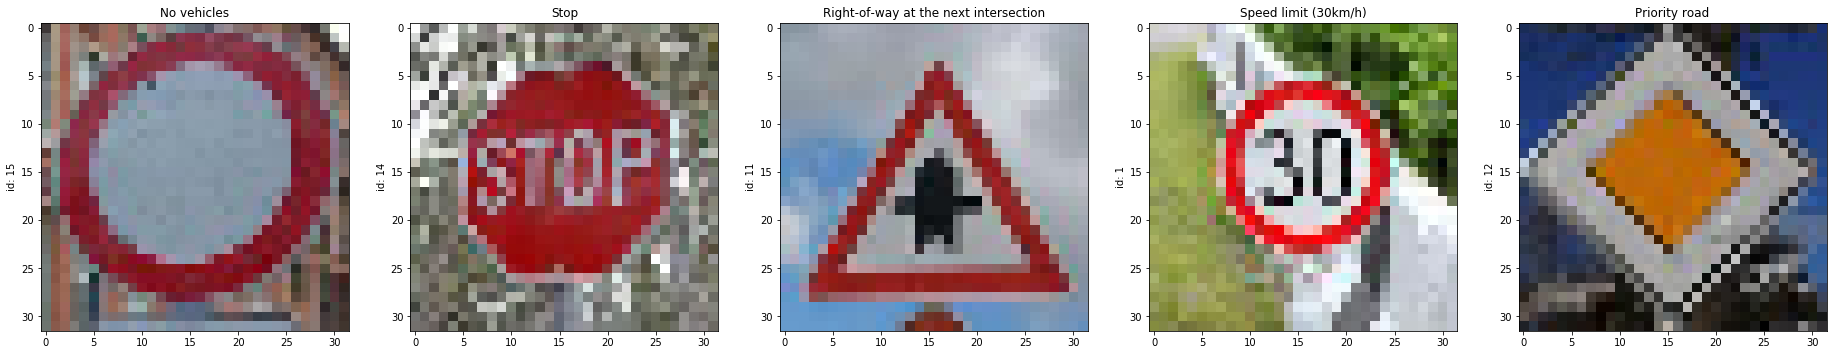

In [10]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import cv2
import matplotlib.image as mpimg

image_path = os.listdir("NewImages")
n_images = list()
n_labels = list()

# read images from directory and resize
for impath in image_path:
    img = mpimg.imread(os.path.join("NewImages", impath))
    img = cv2.resize(img, image_shape[0:2], interpolation=cv2.INTER_CUBIC)
    n_images.append(img)
    
# The prefix of every image name is the category number of the traffic sign
    n_labels.append(int(impath[0:impath.find('-')]))
    
n_images = np.array(n_images)
n_labels = np.array(n_labels)

# keep an original copy
n_images_gold = n_images
n_labels_gold = n_images

# Output the re-sized images
imdim = image_shape[0]
fig = plt.figure(figsize=(imdim,imdim))
for i in range(0, len(n_images)):
    ax = fig.add_subplot(1, len(n_images), i+1)
    ax.set_title(sign_labels[int(n_labels[i])])
    ax.set_ylabel("id: {id}".format(id=n_labels[i]))
    plt.imshow(n_images[i])
plt.show()

### Predict the Sign Type for Each Image

In [11]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Pre-process the new images 
n_images_norm = (n_images - n_images.mean()) / (np.max(n_images) - np.min(n_images))
n_images = n_images_norm

#Make a prediction on the new images using the trained model
with tf.Session() as sess:
    saver.restore(sess, './TrSignClass.ckpt')
    sign_ids = sess.run(tf.argmax(logits, 1), feed_dict={x: n_images, y: n_labels, keep_prob: 1})

# output the results in the table
print('-' * 98)
print(" {p:^48} | {a:^48} ".format(p='PREDICTED', a='ACTUAL'))
print('-' * 98)
for i in range(len(sign_ids)):
    print(' {p:^2} {strp:^45} | {a:^2} {stra:^45} '.format(
        p=sign_ids[i], strp=sign_labels[int(sign_ids[i])], a=n_labels[i], stra=sign_labels[int(n_labels[i])]))

--------------------------------------------------------------------------------------------------
                    PREDICTED                     |                      ACTUAL                      
--------------------------------------------------------------------------------------------------
 15                  No vehicles                  | 15                  No vehicles                  
 14                     Stop                      | 14                     Stop                      
 11     Right-of-way at the next intersection     | 11     Right-of-way at the next intersection     
 1              Speed limit (30km/h)              | 1              Speed limit (30km/h)              
 12                 Priority road                 | 12                 Priority road                 


### Analyze Performance

In [12]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

TopKV2(values=array([[  9.94849861e-01,   4.02608421e-03,   8.81813059e-04,
          1.12682443e-04,   1.00235797e-04],
       [  1.00000000e+00,   8.13595025e-11,   4.84609965e-12,
          1.13828619e-12,   5.86009973e-13],
       [  1.00000000e+00,   3.91001509e-10,   1.69469216e-13,
          3.75367309e-15,   4.89435337e-21],
       [  9.99663353e-01,   3.32848547e-04,   2.58253181e-06,
          6.62717923e-07,   3.61570244e-07],
       [  1.00000000e+00,   3.79511037e-15,   4.28620310e-17,
          3.68460689e-17,   2.11135928e-18]], dtype=float32), indices=array([[15, 13,  2,  9, 39],
       [14, 17,  3,  1, 29],
       [11, 30, 18, 27, 26],
       [ 1, 14,  2,  0,  5],
       [12, 10, 17, 13, 42]], dtype=int32))


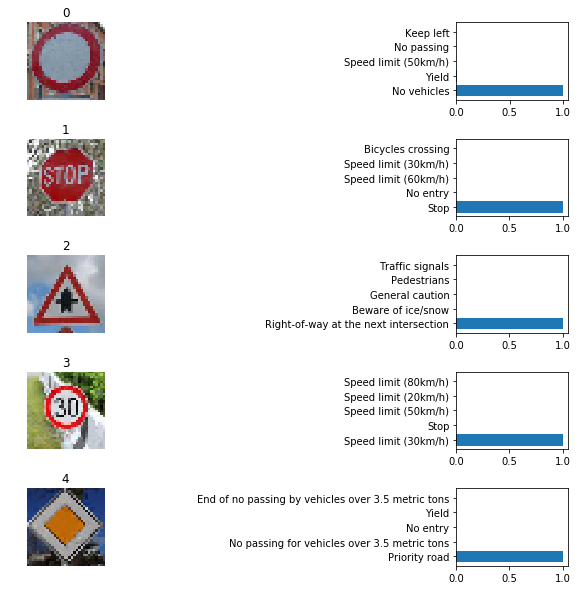

In [13]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
# Print out the top five softmax probabilities for the predictions on 
# the German traffic sign images found on the web. 

with tf.Session() as sess:
    saver.restore(sess, './TrSignClass.ckpt')
    top_5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), 
                     feed_dict={x: n_images, y: n_labels, keep_prob: 1})
print(top_5)

plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(5, 2, 2*i+1)
    plt.subplots_adjust(wspace=3, hspace=0.5)
    plt.imshow(n_images_gold[i]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(5, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), top_5.values[i, :])
    labelss=[sign_labels[j] for j in top_5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labelss)
plt.show()


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")